In [139]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import plot_yearly
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from IPython.display import display
from geopy.geocoders import Nominatim
import datetime as dt


In [140]:
#place = input ("Enter Address :")
place = "408 brook pine trl, apex, nc"

In [141]:
geolocator = Nominatim(user_agent="Test")
location = geolocator.geocode(place)
location

Location(Brook Pine Trail, Town of Apex, Wake County, North Carolina, 27519-9443, United States, (35.7625474, -78.8912379, 0.0))

In [142]:
years = ['2016','2017','2018','2019']
df = []

lat, lon =  location.latitude, location.longitude
api_key = '5qyFRrBVjEZIGuR0WEcihqCEcg4LV8DbErgE6rze'
attributes = 'ghi'
leap_year = 'false'
interval = '30'
utc = 'false'
your_name = 'Anthony+N'
reason_for_use = 'testing'
your_affiliation = 'ECU'
your_email = 'natalea20@students.ecu.edu'
mailing_list = 'false'

for year in years:
    url = 'https://developer.nrel.gov/api/solar/nsrdb_psm3_download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}'.format(year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, email=your_email, mailing_list=mailing_list, affiliation=your_affiliation, reason=reason_for_use, api=api_key, attr=attributes)
    df.append(pd.read_csv(url, skiprows=2))    

# Concatenate Multiple year data into one DataFrame
big_frame = pd.concat(df, ignore_index=True)


In [143]:
big_frame.head(5).append(big_frame.tail(5))

,Year,Month,Day,Hour,Minute,GHI
0,2016,1,1,0,0,0
1,2016,1,1,0,30,0
2,2016,1,1,1,0,0
3,2016,1,1,1,30,0
4,2016,1,1,2,0,0
70075,2019,12,31,21,30,0
70076,2019,12,31,22,0,0
70077,2019,12,31,22,30,0
70078,2019,12,31,23,0,0
70079,2019,12,31,23,30,0


In [144]:
#big_frame.sort_values(by=['Year','Month','Day','Hour','Minute'],ascending=True)

In [145]:
# Set the time index in the pandas dataframe:
#big_frame = big_frame.set_index(pd.date_range('1/1/{yr}'.format(yr=2017), freq=interval+'Min', periods=52560 ))
big_frame = big_frame.set_index(pd.date_range('1/1/{yr}'.format(yr=2016), freq=interval+'Min', periods=70080))

#big_frame.reset_index(inplace=True)

# take a look
big_frame.shape

(70080, 6)

In [146]:
# filtering data 
big_frame=big_frame[(big_frame["GHI"]!=0)]

In [147]:
big_frame.head(5).append(big_frame.tail(5))
big_frame.shape

(35412, 6)

In [148]:
big_frame.reset_index(inplace=True)

In [149]:
#New DF with just Index & GHI
prophet_frame = big_frame[['index','GHI']]
prophet_frame.head()

,index,GHI
0,2016-01-01 08:00:00,42
1,2016-01-01 08:30:00,97
2,2016-01-01 09:00:00,155
3,2016-01-01 09:30:00,210
4,2016-01-01 10:00:00,260


In [150]:
#Renaming columns to ds & y
prophet_frame = prophet_frame.rename(columns = {'index':'ds','GHI':'y'})

In [151]:
prophet_frame.head(5).append(prophet_frame.tail(5))

,ds,y
0,2016-01-01 08:00:00,42
1,2016-01-01 08:30:00,97
2,2016-01-01 09:00:00,155
3,2016-01-01 09:30:00,210
4,2016-01-01 10:00:00,260
35407,2019-12-30 15:00:00,340
35408,2019-12-30 15:30:00,262
35409,2019-12-30 16:00:00,177
35410,2019-12-30 16:30:00,92
35411,2019-12-30 17:00:00,21


In [152]:
prophet_frame = prophet_frame.set_index(['ds'])

In [188]:
#Group by to get Daily Values
prophet_frame_new = prophet_frame.groupby(prophet_frame.index.date).sum()
prophet_frame_new.reset_index(inplace=True)
prophet_frame_new = prophet_frame_new.rename(columns = {'index':'ds'})
prophet_frame_new['ds']=pd.to_datetime(prophet_frame_new.ds)

#Drop rows with null values
prophet_frame_new.dropna() 


,ds,y
0,2016-01-01,2856
1,2016-01-02,6704
2,2016-01-03,5227
3,2016-01-04,3073
4,2016-01-05,6998
...,...,...
1455,2019-12-26,4210
1456,2019-12-27,5133
1457,2019-12-28,2777
1458,2019-12-29,3967


<AxesSubplot:xlabel='ds'>

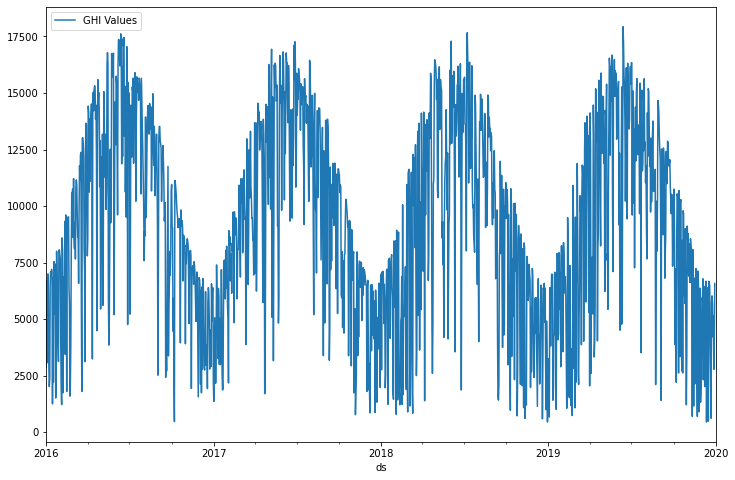

In [212]:
#len(prophet_frame_new)
#train.plot()
#prophet_frame_new.plot(x='ds',y='y',figsize=(12,8),legend=True,label='GHI Values')
prophet_frame_new.plot(x='ds',y='y',figsize=(12,8),legend=True,label='GHI Values',xlim=('2016-01-01','2020-01-01'))


In [239]:
train=prophet_frame_new[:1096]
test=prophet_frame_new[1096:]

In [169]:
#train.tail(5)
#test.head(5)

<AxesSubplot:xlabel='ds'>

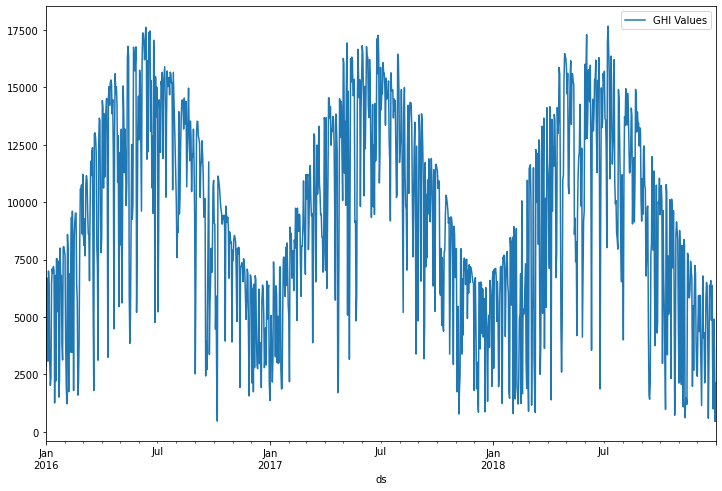

In [208]:
#train.plot()
train.plot(x='ds',y='y',figsize=(12,8),legend=True,label='GHI Values')
#train.plot(x='ds',y='y',figsize=(12,8),legend=True,label='GHI Values',xlim=('2016-01-01','2019-12-31'))


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='ds'>

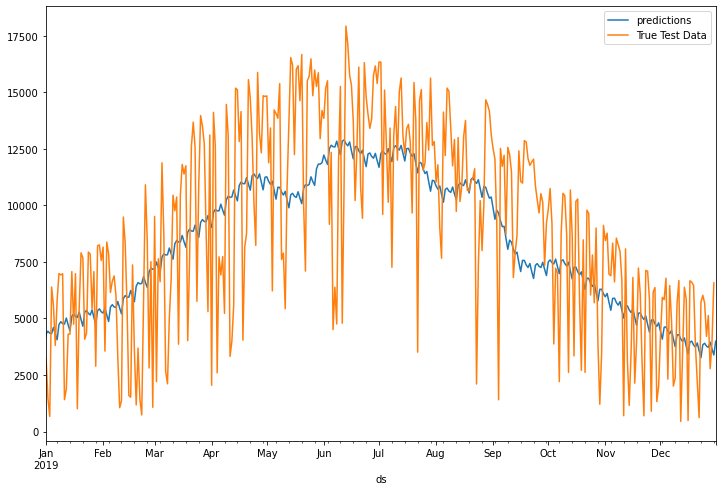

In [240]:
#Model 1
m1=Prophet(seasonality_mode='multiplicative')
m1.fit(train)

future=m1.make_future_dataframe(periods=365,freq = 'D') 
forecast=m1.predict(future)

ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2019-01-01','2019-12-31'))

<AxesSubplot:xlabel='ds'>

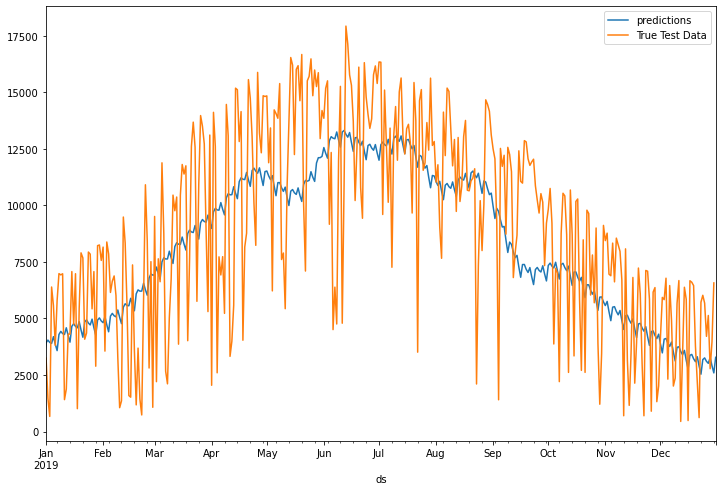

In [243]:
#Model 2
m2 = Prophet(weekly_seasonality=True,daily_seasonality=True,yearly_seasonality=True)
m2.fit(train)

future=m2.make_future_dataframe(periods=365,freq = 'D') 
forecast=m2.predict(future)


ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2019-01-01','2019-12-31'))

<AxesSubplot:xlabel='ds'>

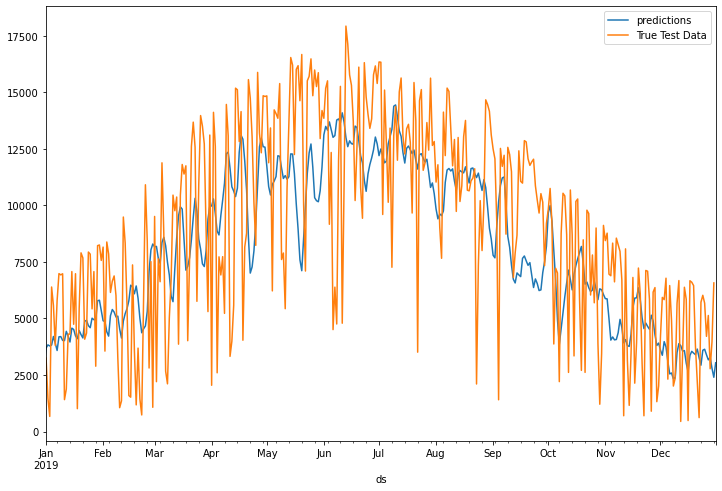

In [242]:
m3 = Prophet(weekly_seasonality=True,daily_seasonality=True,yearly_seasonality=50)
m3.add_seasonality(name='daily', period=365.25, fourier_order=5, prior_scale=0.02)

m3.fit(train)

future=m3.make_future_dataframe(periods=365,freq = 'D') 

forecast=m3.predict(future)


ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2019-01-01','2019-12-31'))

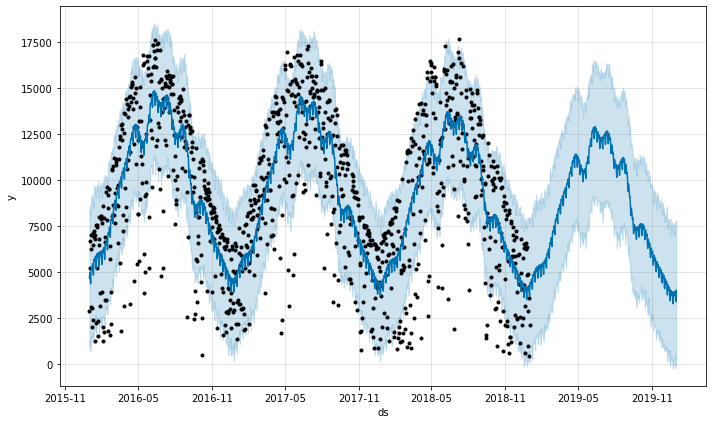

In [220]:
#m.plot(forecast, uncertainty=True)
#plt.show()

<AxesSubplot:xlabel='ds'>

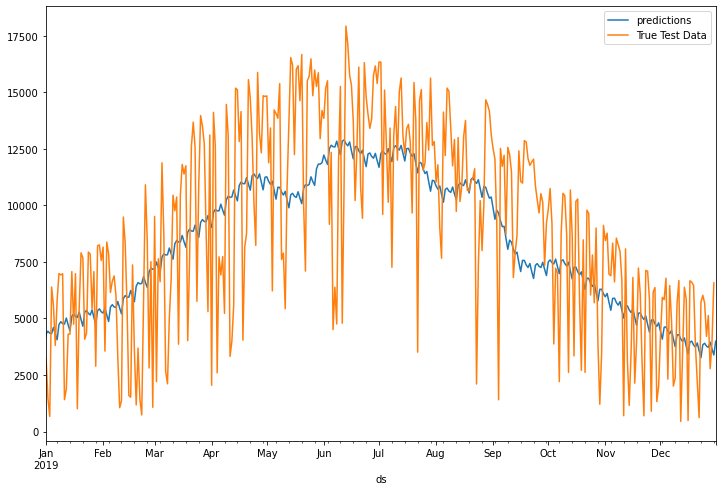

In [233]:
#m.plot(forecast, uncertainty=True)
ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2019-01-01','2019-12-31'))


#ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
#test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax,xlim=('2019-01-01','2019-12-31'))

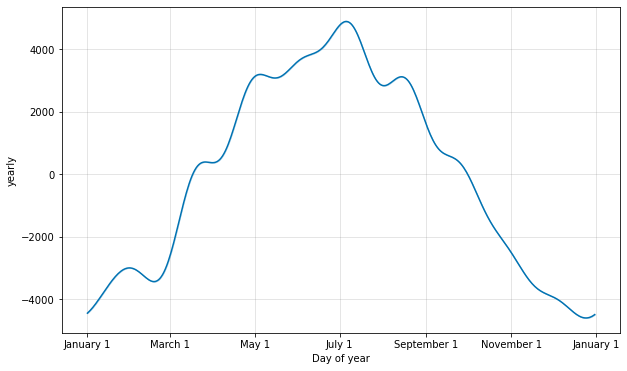

In [79]:
# First fit the model by instantiating a new Prophet object
#m=Prophet(interval_width=0.95)
m = Prophet(interval_width=0.95,weekly_seasonality=True,daily_seasonality=True,yearly_seasonality=True,changepoint_prior_scale=2)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.02)

m.fit(prophet_frame_new)
a = plot_yearly(m)

In [80]:
# Select the Period for future prediction
future = m.make_future_dataframe(periods=730)
future.tail()

,ds
1820,2021-12-26
1821,2021-12-27
1822,2021-12-28
1823,2021-12-29
1824,2021-12-30


In [81]:
# Predict the future values for this time period
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
1820,2021-12-26,1910.676934,-20624.241251,23007.312329
1821,2021-12-27,1920.980035,-20191.922105,23359.662761
1822,2021-12-28,1804.342518,-21126.614155,22893.485728
1823,2021-12-29,2843.562737,-20245.762450,24190.345443
1824,2021-12-30,3331.919807,-19630.224915,24851.875100


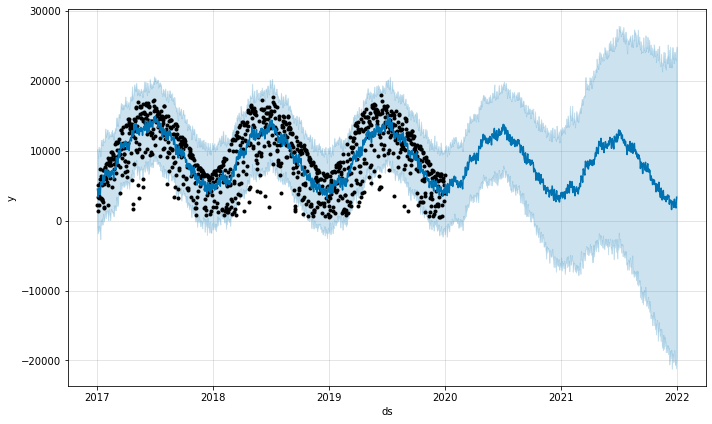

In [82]:
# Python
fig1 = m.plot(forecast)

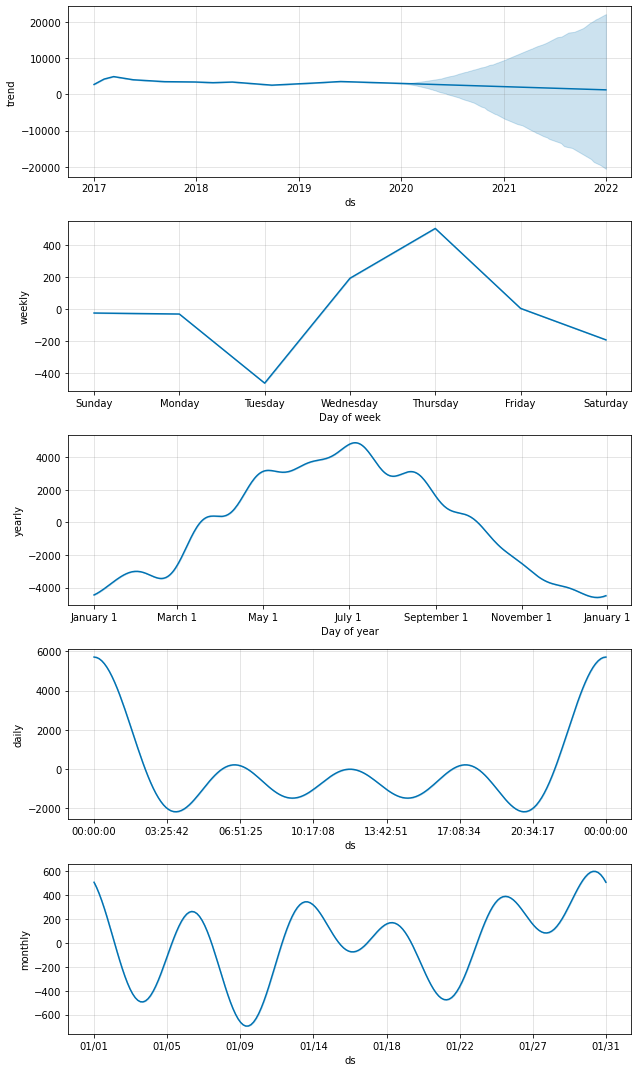

In [83]:
# Python
fig2 = m.plot_components(forecast)


In [23]:
# Python
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)